# Astronomical Images Classification
## Using Deep Learning Convolutional Neural Networks
## By Yosry Negm

<a id='y'></a><h1><font color=blue>Contents</font></h1><br/>   
1. [Definition](#y1)  
    * 1.1. [Project overview](#y11)
    * 1.2. [Problem statement](#y12)
    * 1.3. [Metrics](#y13)
2. [Analysis](#y2)
    * 2.1. [Data exploration](#y21)
    * 2.2. [Exploratory visualization](#y22)
    * 2.3. [Algorithms and techniques](#y23)
    * 2.4. [Benchmark](#y24)
3. [Methodology](#y3)
    * 3.1. [Data processing](#y31)
    * 3.2. [Implementation](#y32)
    * 3.3. [Refinement](#y33)
4. [Results](#y4)
    * 4.1. [Model evaluation and validation](#41)
    * 4.2. [Justification](#42)
5. [Conclusion](#y5)
6. [Future Work](#y6)

## <font color='gray'>Importing Project Libraries</font>

In [1]:
# Importing libraries necessary for the project
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt  
from IPython.display import display
import random
import cv2
from PIL import ImageFile     
import h5py
import itertools    
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import utils
from keras.preprocessing import image 
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.callbacks import ModelCheckpoint 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tqdm import tqdm

Using TensorFlow backend.


## <font color='gray'>Some Custom Settings</font>

In [2]:
# to hide warenings (after finishing the project for neat output)
import warnings
warnings.filterwarnings('ignore')
ImageFile.LOAD_TRUNCATED_IMAGES = True 
%matplotlib inline 
num_of_classes = 2

<a id='y1'></a><h1><font color=blue>1 Definition</font></h1><br/>   

<a id='y11'></a><h2><font color=brown>1.1 Project overview</font></h2><br/>   
<div style="text-align: justify">
Recently, a massive astronomical dataset is being collected to find answers for a variety of unanswered questions about our universe by virtue of modern sky survey instruments. Unfortunately, it is impossible to work on these massive datasets manually to get effective results so, astronomers are seeking approaches to automate the human error borne processes of manual scanning in order to discover astronomical knowledge and information from these large raw datasets i.e. to classify stars, quasars, galaxies and Supernovae (SNe). The problem here, this is done by hand and it is a very time consuming job as well as it is subject to human bias which differs from person to person. In addition, the manual scanning is infeasible for a huge amount of images. From this point of view, I've selected this concrete astronomical classification problem to investigate applying convolutional Neural Networks (CNNs) algorithm to automate this process and then I compared my results to a reference publication as a benchmark model by using the same well-known public dataset of the Sloan Digital Sky Survey (SDSS).
</div>

<img src="sn_gallery.200567.x2.oname.jpg">



[Sloan Digital Sky Survey (SDSS)]

[Sloan Digital Sky Survey (SDSS)]: https://classic.sdss.org/supernova/aboutsupernova.html 
[Back To Table of Contents](#y)

<a id='y12'></a><h2><font color=brown>1.2 Problem statement</font></h2><br/>   
<div style="text-align: justify">
The problem we are trying to solve here is to <b>replace the human hand scanning and classification of artefacts and objects SDSS imaging data</b> which is classified into ten classes (dipoles, artefacts, saturated stars, transients, variables, moving objects, SN Gold, SN Silver, SN Bronze, SN Other) but for simplification purpose it is also reduced to be four visual classes (Real, Artefacts, Saturated, Dipole) by <b>autmating</b> this prcoss via applying <b>deep learning algorithm</b>. For the purpose of the comparison to our benchmark model I have chosen the astronomers' first step which is looking for interesting objects in a<b> binary classification </b>problem of determining what is <b><font color=red>real</font></b> and <b><font color=red>what is not</font></b> in the underlying dataset. 
</div>

[Back To Table of Contents](#y)

<a id='T1'></a>

In [3]:
# Loading human hand scanning original classifications for the objects in SDSS dataset. 
Human_Hand_Scanning_Classification_File = 'classes.csv'
Human_Hand_Scanning_Classification = pd.read_csv(Human_Hand_Scanning_Classification_File)
print('Human hand scanning classification for the objects in the dataset')
display(Human_Hand_Scanning_Classification)

Human hand scanning classification for the objects in the dataset


,Original_Classes,Visual_Classes,Binary_Classes,Description
0,Artefact,Artefact,Not-Real,Residuals caused by problems in the image
1,Dipole,Dipole/Saturated,Not-Real,Residuals caused by errors in image registration
2,Saturated Star,Dipole/Saturated,Not-Real,Residuals of stars that saturate the CCD
3,Moving,Real,Real,Anything showing signs of motion
4,Variable,Real,Real,Objects showing a record of long-term variability
5,Transient,Real,Real,Objects with no observation history
6,SN Other,Real,Real,Objects that are thought to be SNe
7,SN Bronze,Real,Real,residuals at the centre of their host galaxies
8,SN Silver,Real,Real,SNe much more luminous
9,SN Gold,Real,Real,Possible SNe identified


<a id='y13'></a><h2><font color=brown>1.3 Metrics</font></h2><br/>   
<div style="text-align: justify">
For evaluating the results of my work and comparing it to the selected benchmark model I will use the same four metrics of performance measure that used there. The four measures that are used in this comparison are commonly applied to classification problems and they are Accuracy (A), Precision (P), Recall (R), and F1-Score. They are defined in terms of true/false positives/negatives (tp, tn, fp, fn). where positive classes are those corresponding to real objects, Accuracy will be a reasonable initial measure since the classes in our dataset are all of similar sizes while Precision reflects the fraction of reported real objects that are so. We could define Recall as the fraction of true objects that are found by the classifier, but F1-Score is expressed in terms of Precision and Recall, it could be considered as a measure that punishes false negatives and false positives equally but weighted by their inverse fractional contribution to the full set to account for large class number hierarchies.
</div>

[Classification Performance metrics]

[Classification Performance metrics]: https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative


In [4]:
def Metrics(testClassess,predictedClasses):
    X =np.copy(np.argmax(testClassess, axis=1))
    Y = np.copy(predictedClasses)
    Z=np.bitwise_xor(X,Y)
    TrueValues=Y[np.where(Z==0)]
    FalseValues=Y[np.where(Z==1)]
    tvIndices, tvCounts = np.unique(TrueValues, return_counts=True)
    fvIndices, fvCounts = np.unique(FalseValues, return_counts=True)
    Tn=tvCounts[0]
    Tp=tvCounts[1]
    Fn=fvCounts[0]
    Fp=fvCounts[1]  
    A=(Tp+Tn)/(Tp+Tn+Fp+Fn)
    P=Tp/(Tp+Fp)
    R=Tp/(Tp+Fn)
    F1=(2*P*R)/(P+R)
    TPR=R
    FPR=Fp/(Fp+Tn)
    return A,P,R,F1,TPR,FPR    

In [5]:
def ConfusionMatrix(cm, classes,title='Confusion matrix',cmap=plt.cm.jet):
    """
    This function prints and plots the confusion matrix.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
def ModelPerformance(model,mHistory,testClassess,predictedClasses):
    A,P,R,F1,TPR,FPR=Metrics(testClassess,predictedClasses)
    print('Test accuracy: %.2f %%' % (A*100))
    print('Test Precision: %.2f %%' % (P*100))
    print('Test Recall or (TPR): %.2f %%' % (R*100))
    print('Test F1-Score: %.2f %%' % (F1*100))
    print('Test Fall-out (FPR): %.2f %%' % (FPR*100))    
    accuracy = mHistory.history['acc']
    val_accuracy = mHistory.history['val_acc']
    loss = mHistory.history['loss']
    val_loss = mHistory.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    conf_mat =confusion_matrix(np.argmax(testClassess, axis=1),predictedClasses)
    plt.figure()
    ConfusionMatrix(conf_mat, classes=["Not Real","Real"])
    plt.show()
    
    fpr, tpr, _ = roc_curve(np.argmax(testClassess, axis=1), predictedClasses)
    auc_score = auc(fpr, tpr)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
    # it's helpful to add a diagonal to indicate where chance 
    # scores lie (i.e. just flipping a coin)
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

[Back To Table of Contents](#y)

<a id='y2'></a><h1><font color=blue>2 Analysis</font></h1><br/>   

## <font color='gray'>Loading data</font>

In [7]:
# Loading images,labels and original classes of the SDSS dataset
with h5py.File('sdss.hdf5', 'r') as SDSS:
        images = np.array(SDSS['images'])
        labels = np.array(SDSS['classes'])
Total_number_of_data_points=images.shape[0]
# Loading human hand scanning original classifications for the objects in SDSS dataset. 
Human_Hand_Scanning_Classification_File = 'classes.csv'
Human_Hand_Scanning_Classification = pd.read_csv(Human_Hand_Scanning_Classification_File)
print("Dataset contains %d images, manually labeled into  %d  original classifications by human scanneers at SDSS."% (Total_number_of_data_points,labels.max()-labels.min()+1))

Dataset contains 21785 images, manually labeled into  10  original classifications by human scanneers at SDSS.


<a id='y21'></a><h2><font color=brown>2.1 Data exploration</font></h2><br/>   
<div style="text-align: justify">
   As shown in the <a href='#T1'>above table</a>, The description of different classifications for each of the 10 original classes used by the <b>human hand scanning </b>for objects in the data set could clearfied as follows:-
    
- **Artefact**: Residuals caused by problems in the image (e.g. diffraction spikes), this is considered (<b><font color=red>Not-Real</color></b>)
- **Dipole**: Residuals with roughly equal amounts of positive and negative flux, caused by errors in image registration,this is considered (<b><font color=red>Not-Real</color></b>)
- **Saturated star**: Residuals of stars that saturate the CCD, this is considered (<b><font color=green>Real</color></b>)
- **Moving**: Anything showing signs of motion between cutouts in different passbands, this is considered (<b><font color=green>Real</color></b>)
- **Variable**: Objects showing a record of long-term variability, this is considered (<b><font color=green>Real</color></b>)
- **Transient**: Objects with no observation history, no apparent host galaxy in the search image and no motion, this is considered (<b><font color=green>Real</color></b>)
- **SN Other**: Objects that are thought to have a good chance of being SNe, but that do not fit nicely into any of the above classes, this is considered (<b><font color=green>Real</color></b>)
- **SN Bronze**: Point-like residuals at the centre of their host galaxies, most of the objects in this class later turn out to be either quasars (QSOs), active galactic nuclei (AGN) or, foreground variable stars, and not SNe, this is considered (<b><font color=green>Real</color></b>)
- **SN Silver**: Point-like residuals having no apparent host galaxy, SNe much more luminous than their host galaxies usually fall into this class, this is considered (<b><font color=green>Real</color></b>)
- **SN Gold** Possible SNe identified as point-like residuals that are not at the exact centre of their host galaxies, this is considered (<b><font color=green>Real</color></b>).
</div>

In [8]:
def Class_Count_by_id(c):
    unique, counts = np.unique(labels, return_counts=True)
    return counts[c]
def ViewClassImages(c):
    imgs = np.where(labels==c)
    dx=random.randint(np.min(imgs),np.max(imgs))
    plt.imshow(np.array(images[dx]))
def Visualize_Sample(c):
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    sample_size=20
    dxs=np.where(labels==c)
    for i in range(1, sample_size+1):
        dx=random.randint(0,len(dxs[0]))
        ax = fig.add_subplot(4, 5, i)
        ax.imshow(np.array(images[dxs[0][dx]]))
        ax.set_title(Human_Hand_Scanning_Classification.at[labels[dxs[0][dx]],'Original_Classes'])
        ax.set_xticks([])
        ax.set_yticks([])
# Defining function to count the total number of data points of a certain class and class type in a specified dataset
def Class_Count(Data_set,Class_Type):
        unique, counts = np.unique(Data_set, return_counts=True)
        if Class_Type=='Original_Classes':
            ticks=Human_Hand_Scanning_Classification[Class_Type]
            return unique, counts,ticks
        elif Class_Type=='Visual_Classes':
            uniqueV=[0,1,2]
            ticksV=['Artefact','Dipole/saturated','Real'] 
            countsV=[]
            countsV.append(counts[0])
            countsV.append(sum(counts[1:2]))
            countsV.append(sum(counts[3:9]))
            return uniqueV, countsV,ticksV
        elif Class_Type=='Binary_Classes': 
            uniqueB=[0,1]
            ticksB=['Not-Real','Real']          
            countsB=[]
            countsB.append(sum(counts[0:2]))
            countsB.append(sum(counts[3:9]))
            return uniqueB, countsB,ticksB  
def visualize_Classes_Count(Data_set,Class_Type):
    xValues, yValues,tValues = Class_Count(Data_set,Class_Type)
    plt.barh(xValues,yValues)
    plt.yticks(xValues, tValues)
    plt.title(Class_Type.replace("_", " "))        

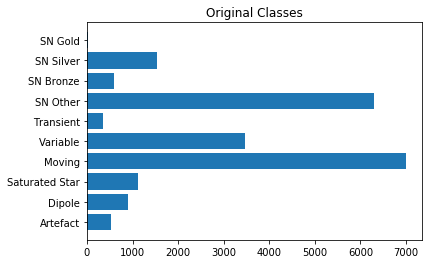

In [9]:
visualize_Classes_Count(labels,'Original_Classes')

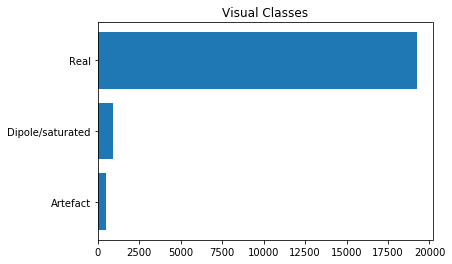

In [10]:
visualize_Classes_Count(labels,'Visual_Classes')

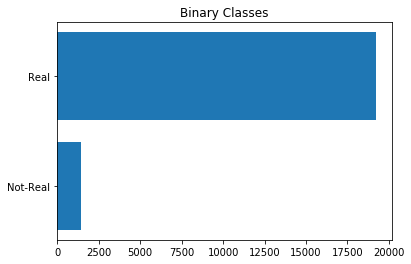

In [11]:
visualize_Classes_Count(labels,'Binary_Classes')

In [12]:
a, b = np.unique(labels, return_counts=True)
print('There are {:10.2f} % of the Original dataset are manually classified as real objects.'.format(sum(b[3:9]*100/len(images))))

There are      88.24 % of the Original dataset are manually classified as real objects.


[Back To Table of Contents](#y)

<a id='y22'></a><h2><font color=brown>2.2 Exploratory visualization</font></h2><br/>   
<div style="text-align: justify">
     
</div>

In [13]:
def Visualize_Sample(classifications_type='Binary_Classes'):
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    sample_size=20
    for i in range(1, sample_size+1):
        dx=random.randint(0,Total_number_of_data_points-1)
        ax = fig.add_subplot(4, 5, i)
        ax.imshow(np.array(images[dx]))
        ax.set_title(Human_Hand_Scanning_Classification.at[labels[dx],classifications_type])
        ax.set_xticks([])
        ax.set_yticks([])

## <font color='gray'>Original Classes</font>

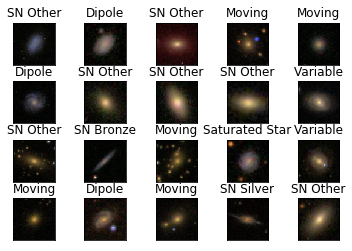

In [14]:
# Sample of original classes
Visualize_Sample('Original_Classes')

## <font color='gray'>Visual Classes</font>

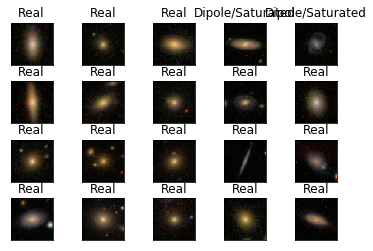

In [15]:
# Sample of original classes
Visualize_Sample('Visual_Classes')

[Back To Table of Contents](#y)

## <font color='gray'>Binary Classes</font>

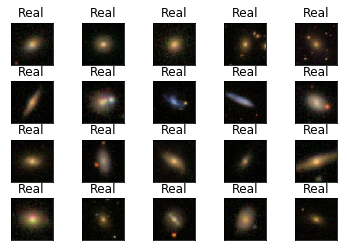

In [16]:
# Sample of Binary_Classes
Visualize_Sample()

<a id='y23'></a><h2><font color=brown>2.3 Algorithms and techniques</font></h2><br/>   
<div style="text-align: justify">
To solve the proposed problem, I have built the learning model using the deep learning algorithm which was inspired by the biological visual cortex in human brain named deep feed-forward convolutional neural network (CNN or ConvNet). I have implemented it in Python programming language with Keras inside Jupiter Notebook (IPython) depending on using Numpy, Pandas, and Scikit-Learn packages. The reason behind choosing this algorithm is that it reduces the number of parameters and extracts highly robust non-linear features. As well as, it learns hierarchical representations of the data using local receptive fields, sparse connectivity, sharing weights, pooling, and deep architecture. We constructed this network by adding many layers, some for feature representations known as feature maps. After building, compiling, training and evaluating our model we have tuned its hyper-parameters, then re-train and re-evaluate it again then compared our final results to the bench mark model
</div>

[Back To Table of Contents](#y)

<a id='y24'></a><h2><font color=brown>2.4 Benchmark</font></h2><br/>   
<div style="text-align: justify">
    Most of the similar works to this project had been focused on SN Factory  prior work (Roman, Aragon & Ding in 2006 and Bailey 2007) utilizing classical supervised learning algorithms to accomplish the task of automatic classification. As a benchmark model for my work, I will suggest the publication titled " Machine learning classification of SDSS transient survey images "  . This research works on the same dataset, but used different learning algorithms such as Random forest, k-nearest neighbors, Naïve Bayes, and Support vector machine (SVM). Then it compares their performance using the same measure metrics I will use, in other words I will rework this research but using deep learning convolutional networks and then compare my work to the prior work. But on contrast they depend on Principal Component Analysis Algorithm (PCA) to extract features like attributes as shape, position, Full-Width Half Maximum (FWHM), and distance to the nearest object in the difference image  as well as SDSS Camera filters (g, r, i, z, u) , In our solution there is no need to process feature extraction by using PCA but our CNN will learn them.
</div>

[Benchmark Paper]

[Benchmark Paper]: https://academic.oup.com/mnras/article/454/2/2026/1051683

[Back To Table of Contents](#y)

<a id='y3'></a><h1><font color=blue>3 Methodology</font></h1><br/>   

<a id='y31'></a><h2><font color=brown>3.1 Data processing</font></h2><br/>   
<div style="text-align: justify">
    
</div>

In [17]:
# converting the original classes to binary classes (0-Not-Real,1-Real)
Labels=np.copy(labels)
Labels[np.where(Labels<=2)]=0  # The first three labels (Artefact, Dipole, Satuarted Star) are considered Not-Real objects
Labels[np.where(Labels>2)]=1   # The remaining are classified as Real objects
uniqueL, countsL = np.unique(labels, return_counts=True)
print('There are {:10.2f} % of the Original dataset are considered as real objects.'.format(sum(countsL[3:9]*100/len(images))))
# converting labels to categorical 10 classes using One hot encoding technique
Labels = utils.to_categorical(Labels, 2)
LDF=pd.DataFrame(Labels)
display(LDF.head(20))

There are      88.24 % of the Original dataset are considered as real objects.


,0,1
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,1.0,0.0


## <font color='gray'>Spliting Dataset into Training,Test, and Validation sets</font>

<div style="text-align: justify"> 
To compare with our benchmark model, we will start by hold 25% of the data points for testing purpose (Test set) and the remaining will be use in training our model (Training set). Later, and for optimization purpose we will perform cross-validation by using 30% of the starting training set as validation and the remaining 70% for re-training our model in ordr eliminate biasing during opimization and tuning our model to get real and fair results compared to the algorithms used in our reference benchmark.    
</div>

In [18]:
tmp_idx, test_idx = train_test_split(np.arange(Labels.shape[0]), test_size=0.25)
tmp_images, tmp_labels, test_images, test_labels = images[tmp_idx], Labels[tmp_idx], images[test_idx], Labels[test_idx]

In [19]:
train_idx, valid_idx = train_test_split(np.arange(tmp_labels.shape[0]), test_size=0.30)
train_images, train_labels, valid_images, valid_labels = tmp_images[train_idx], tmp_labels[train_idx], tmp_images[valid_idx], tmp_labels[valid_idx]

In [20]:
# Dataset statistics
print(' Dataset statistics ')
print('---------------------')
print('There are %d total Original Classes (categories), 3 Visual classes and 2 binary classes.' % len(Human_Hand_Scanning_Classification))
print('........................................................................................')
print(' Splitting data (Test, Train, and Validation)')
print('---------------------')

print('The original dataset contains %d images.' % len(images))
print('The Test dataset contains {} images i.e {:10.2f} % from th original datset'.format(test_images.shape[0],test_images.shape[0]*100/images.shape[0]))
print('The Training dataset contains {} images i.e {:10.2f} %  from th original datset'.format(train_images.shape[0],train_images.shape[0]*100/images.shape[0]))
print('The Validation dataset contains {} images i.e {:10.2f} %  from th original datset'.format(valid_images.shape[0],valid_images.shape[0]*100/images.shape[0]))

 Dataset statistics 
---------------------
There are 10 total Original Classes (categories), 3 Visual classes and 2 binary classes.
........................................................................................
 Splitting data (Test, Train, and Validation)
---------------------
The original dataset contains 21785 images.
The Test dataset contains 5447 images i.e      25.00 % from th original datset
The Training dataset contains 11436 images i.e      52.49 %  from th original datset
The Validation dataset contains 4902 images i.e      22.50 %  from th original datset


## <font color='gray'>Preparing data</font>

In [21]:
def img_to_tensor(img):
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def images_to_tensor(imgs):
    list_of_tensors = [img_to_tensor(img) for img in tqdm(imgs)]
    return np.vstack(list_of_tensors)

In [22]:
# preparing images for Keras
train_tensors = images_to_tensor(train_images).astype('float32')/255
valid_tensors = images_to_tensor(valid_images).astype('float32')/255
test_tensors = images_to_tensor(test_images).astype('float32')/255

100%|██████████| 5447/5447 [00:00<00:00, 23817.56it/s]


In [23]:
print('------------------ Tesnors dimensions ------------------------\n' )
print ("Train Tensors Size : ")
print (np.shape(train_tensors))
print ("Valid Tensors Size : ")
print (np.shape(valid_tensors))
print ("Test Tensors Size : ")
print (np.shape(test_tensors))
print ('--------------------------------')
print ("Train Labels Size : ")
print (np.shape(train_labels))
print ("Validation Labels Size : ")
print (np.shape(valid_labels))
print ("Test Labels Size : ")
print (np.shape(test_labels))

------------------ Tesnors dimensions ------------------------

Train Tensors Size : 
(11436, 69, 69, 3)
Valid Tensors Size : 
(4902, 69, 69, 3)
Test Tensors Size : 
(5447, 69, 69, 3)
--------------------------------
Train Labels Size : 
(11436, 2)
Validation Labels Size : 
(4902, 2)
Test Labels Size : 
(5447, 2)


[Back To Table of Contents](#y)

<a id='y32'></a><h2><font color=brown>3.2 Implementation</font></h2><br/>   
<div style="text-align: justify">
   
</div>


## <font color='gray'>Model Architecture </font>

Our solution started with initial model of <b><font color='green'>CNN Network</font></b> constructed of <b>three convolutional layers</b> as follows:<br>
* The first layer contains 32 filters of size 3 x 3,
* The second layer contains 64 filters of size 3 x 3, and
* The third layer contains 128 filters of size 3 x 3.<br>
In addition, there are <b>three max-pooling layers</b> each of size 2 x 2.


In [24]:
batch_size = 64
epochs_count = 50

intial_model = Sequential()
intial_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(train_tensors.shape[1:]),padding='same'))
intial_model.add(MaxPooling2D((2, 2),padding='same'))
intial_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
intial_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
intial_model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))      
intial_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
intial_model.add(Flatten())
intial_model.add(Dense(128, activation='relu'))          
intial_model.add(Dense(num_of_classes, activation='softmax'))
intial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 69, 69, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10368)             0         
__________

## <font color='gray'>Compiling the model </font>

In [25]:
intial_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

## <font color='gray'>Train the model </font> 

In [26]:
# number of epochs used to train the model.

epochs = epochs_count

checkpointer1 = ModelCheckpoint(filepath='saved_models/weights1.best.cnn.sdss.hdf5',verbose=1, save_best_only=True)

history1 =intial_model.fit(train_tensors, train_labels,validation_data=(valid_tensors, valid_labels),epochs=epochs, batch_size=batch_size, callbacks=[checkpointer1], verbose=1)

Train on 11436 samples, validate on 4902 samples
Epoch 1/50
11436/11436 [==============================] - 10s 913us/step - loss: 0.3060 - acc: 0.8803 - val_loss: 0.2416 - val_acc: 0.9080
Epoch 2/50
11436/11436 [==============================] - 9s 792us/step - loss: 0.2439 - acc: 0.8941 - val_loss: 0.2131 - val_acc: 0.9094
Epoch 3/50
11436/11436 [==============================] - 9s 770us/step - loss: 0.2273 - acc: 0.9051 - val_loss: 0.2191 - val_acc: 0.9121
Epoch 4/50
11436/11436 [==============================] - 9s 769us/step - loss: 0.2063 - acc: 0.9100 - val_loss: 0.1863 - val_acc: 0.9143
Epoch 5/50
11436/11436 [==============================] - 9s 784us/step - loss: 0.1871 - acc: 0.9217 - val_loss: 0.1976 - val_acc: 0.9102
Epoch 6/50
11436/11436 [==============================] - 9s 786us/step - loss: 0.1695 - acc: 0.9301 - val_loss: 0.2068 - val_acc: 0.9068
Epoch 7/50
11436/11436 [==============================] - 9s 785us/step - loss: 0.1637 - acc: 0.9307 - val_loss: 0.1694 - 

## <font color='gray'>Load the Model with the Best Validation Loss </font>

In [27]:
intial_model.load_weights('saved_models/weights1.best.cnn.sdss.hdf5')

## <font color='gray'>Load the Model with the Best Validation Loss </font>

In [28]:
# get index of predicted Astronomical Objects for each image in test set
predictions1 = [np.argmax(intial_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

## <font color='gray'>Intial Model Evaluation </font>

Test accuracy: 93.13 %
Test Precision: 95.83 %
Test Recall or (TPR): 96.43 %
Test F1-Score: 96.13 %
Test Fall-out (FPR): 31.86 %


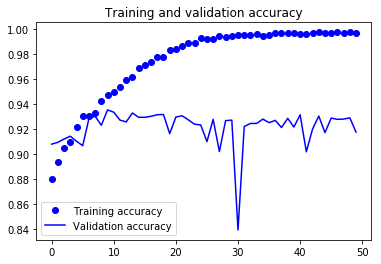

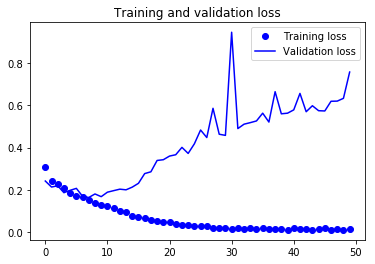

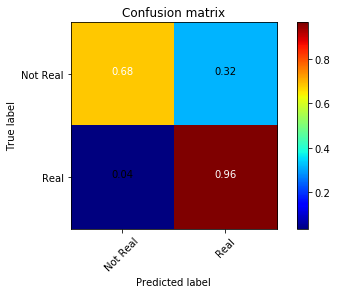

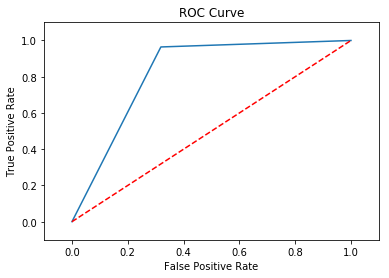

In [29]:
ModelPerformance(intial_model,history1,test_labels,predictions1)

[Back To Table of Contents](#y)

<a id='y33'></a><h2><font color=brown>3.3 Refinement</font></h2><br/>   
<div style="text-align: justify">
After training and evaluating our initial and by observing the training accuracy and loss, I could say that the model did a good job since after 50 epochs the training accuracy is 93.13 % and the training loss is quite low. However, it looks like the model is Overfitting, gives an intuition that the network has memorized the training data very well but is not guaranteed to work on unseen data, and that is why there is a difference in the training and validation accuracy. So I have tried some optimization techniques such as trying to add more hidden layers of Convolution Filters, changing the size of window of MaxPool layer to get enhanced Feature Extraction, performing data augmentation, Regularization by putting dropout layers to avoid overfitting and other techniques until the model generalizes better and provides the desired output that works well for the astronomical images binary classification into real objects and Non-Real Objects task. Also I have changed the optimization algorithm by using Adam optimizer and increasing both number of epochs to 200 and batch size to 128.
</div>


[Back To Table of Contents](#y)

In [30]:
batch_size = 128
epochs_count = 200

tuned_model = Sequential()
tuned_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(train_tensors.shape[1:])))
tuned_model.add(LeakyReLU(alpha=0.1))
tuned_model.add(MaxPooling2D((2, 2),padding='same'))
tuned_model.add(Dropout(0.25))
tuned_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
tuned_model.add(LeakyReLU(alpha=0.1))
tuned_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
tuned_model.add(Dropout(0.25))
tuned_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
tuned_model.add(LeakyReLU(alpha=0.1))                  
tuned_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
tuned_model.add(Dropout(0.4))
tuned_model.add(Flatten())
tuned_model.add(Dense(128, activation='linear'))
tuned_model.add(LeakyReLU(alpha=0.1))           
tuned_model.add(Dropout(0.3))
tuned_model.add(Dense(num_of_classes, activation='softmax'))
tuned_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 69, 69, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 69, 69, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 35, 35, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 35, 35, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)        0         
__________

In [31]:
tuned_model.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
# number of epochs used to train the model.

epochs = epochs_count


checkpointer2 = ModelCheckpoint(filepath='saved_models/weights2.best.cnn.sdss.hdf5',verbose=1, save_best_only=True)

history2 =tuned_model.fit(train_tensors, train_labels,validation_data=(valid_tensors, valid_labels),epochs=epochs, batch_size=batch_size, callbacks=[checkpointer2], verbose=1)

Train on 11436 samples, validate on 4902 samples
Epoch 1/200
11436/11436 [==============================] - 12s 1ms/step - loss: 0.3023 - acc: 0.8813 - val_loss: 0.2911 - val_acc: 0.8890
Epoch 2/200
11436/11436 [==============================] - 11s 991us/step - loss: 0.2501 - acc: 0.8930 - val_loss: 0.2566 - val_acc: 0.9015
Epoch 3/200
11436/11436 [==============================] - 11s 981us/step - loss: 0.2436 - acc: 0.8955 - val_loss: 0.3133 - val_acc: 0.8937
Epoch 4/200
11436/11436 [==============================] - 11s 993us/step - loss: 0.2282 - acc: 0.9004 - val_loss: 0.2585 - val_acc: 0.9023
Epoch 5/200
11436/11436 [==============================] - 11s 996us/step - loss: 0.2208 - acc: 0.9014 - val_loss: 0.2286 - val_acc: 0.9102
Epoch 6/200
11436/11436 [==============================] - 11s 993us/step - loss: 0.2091 - acc: 0.9076 - val_loss: 0.2094 - val_acc: 0.9143
Epoch 7/200
11436/11436 [==============================] - 11s 984us/step - loss: 0.2067 - acc: 0.9110 - val_loss

In [33]:
tuned_model.load_weights('saved_models/weights2.best.cnn.sdss.hdf5')

In [34]:
# get index of predicted Astronomical Objects for each image in test set
predictions2 = [np.argmax(tuned_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

## <font color='gray'>Tuned Model Evaluation </font>

Test accuracy: 92.36 %
Test Precision: 94.93 %
Test Recall or (TPR): 96.51 %
Test F1-Score: 95.71 %
Test Fall-out (FPR): 39.12 %


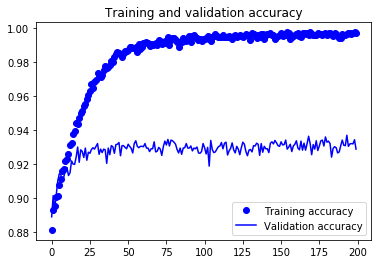

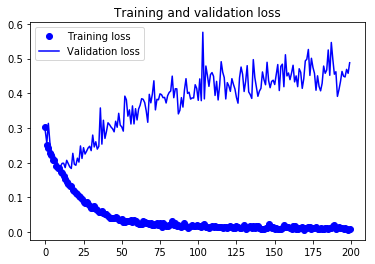

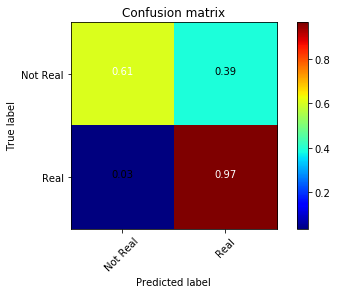

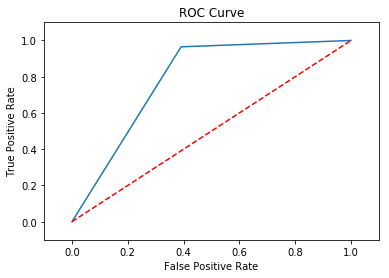

In [35]:
ModelPerformance(tuned_model,history2,test_labels,predictions2)

<a id='y4'></a><h1><font color=blue>4 Results</font></h1><br/>   

<a id='y41'></a><h2><font color=brown>4.1 Model evaluation and validation</font></h2><br/>   
<div style="text-align: justify">
I have used the training set to tune the model parameters where the model learns from training data. But, in order to produce an independent measure of the model's performance a test set was used. the final test and evaluation results are:
</div>

- Accuracy =92.36 %
- Recall=96.51 %
- Precession=94.93 %
- F1-score= 95.71 %

			
			


[Back To Table of Contents](#y)

<a id='y42'></a><h2><font color=brown>4.2 Justification</font></h2><br/>   
<div style="text-align: justify">
In our solution as in the benchmark model, we considered the Accuracy and Recall to be the most important performance metrics since the two main classes in our data (Real objects and Non-real objects) are of similar sizes, Accuracy serves as a good general measure of performance, while Recall was chosen because we are more concerned with missing true objects (false negatives) than we are with contaminating our set of predicted objects with false positives since these are easy to human to exclude. These results suggest that it does in fact have a positive role to play in future astronomical surveys. Deep learning methods prove to be perfect player in this field, if not better, than human scanners; but unlike astronomers they can classify thousands of transients in a second. Unlike conventional machine learning algorithms convolutional neural networks require no complex and case-specific features to be crafted. With only data-augmentation during training, convolutional neural networks discover their own abstract features for classification. Deep models can provide continuous-valued scores for classification certainty that may be tuned, unlike human scanners, for best recall and precision. In addition, they are capable of handling such large data throughputs as may be generated by the Large Synoptic Survey Telescope through heavy utilization of GPUs. Deep models, in particular Convolutional Neural Networks, are indispensable for future astronomical sky surveys such as the LSST.
</div>


[Back To Table of Contents](#y)

<a id='y5'></a><h1><font color=blue>5 Conclusion</font></h1><br/>   

<div style="text-align: justify">
The benchmark model we are comparing with is examining a variety of machine learning algorithms for transient classification was simplified to perform the primary process of binary classification for the objects in the astronomical imaging data into Real and Non-Real objects. From the bench mark results we note that the best classifier was used is Random Forest (RF) with Accuracy and Recall at 91%. As well as it uses Neural Network called SkyNet that gives Accuracy of 88% and Recall of 89 %. But our final result using Deep Learning Convolutional Network (CNN) gives a good acceptable accuracy of 92.36 % and Recall 96.51 %, I have tried to get optimal solution for the problem and showing that using machine learning algorithms especially deep learning could exceed human manual scanning process and I think I have reached this goal with some degree.
</div>



[Back To Table of Contents](#y)

<a id='y6'></a><h1><font color=blue>6 Future Work</font></h1><br/>   

<div style="text-align: justify">
Regarding future work using, my solution model working now on binary classification but I think as improvement, it should be upgraded to perform multi-classification of different categories in the imaging data to be more practical and useful tool for classification of supernovae and other objects in astronomical imaging data. As well as inject my future model with truly massive data sets considering the training to be done on GPUs. Also preprocessing algorithms may be developed for handling Signal-to-noise ratio and preparing difference images and centering candidate transients. In addition, I may include a time-series of images of the region in question, including time durations between scans images as features.
</div>


[Back To Table of Contents](#y)